In [1]:
import Bio.SeqIO as SeqIO
import numpy as np
import pandas as pd
from tqdm import tqdm
import re
import os
import sys

In [2]:
def calc_identity(seq1, seq2, gap_rate=0.8):
    if len(seq1) != len(seq2):
        raise Exception('Sequence not aligned properly!')
    else:
        seq1_np = np.array(list(seq1))
        seq2_np = np.array(list(seq2))

        valid_positions = ~((seq1_np == '-') & (seq2_np == '-') & (seq1_np == seq2_np))
        match_count = np.sum(seq1_np[valid_positions] == seq2_np[valid_positions])
        gap_count = np.sum((seq1_np[valid_positions] == '-') | (seq2_np[valid_positions] == '-'))
        aligned_length = np.sum(valid_positions)

        try:
            pident = match_count / (aligned_length) * 100
        except ZeroDivisionError:
            pident = 'NA'

        return match_count, (aligned_length - match_count), gap_count, aligned_length, len(seq1), pident

In [22]:
def calc_identity(file, gap_rate=0.8):
	result = []
	msafile = file
	aln = SeqIO.to_dict(SeqIO.parse(msafile, format='fasta'))
	aln_seqids = list(aln.keys())
	for i in tqdm(range(len(aln_seqids))):
		for j in range(i+1, len(aln_seqids)):
			seqid_i = aln_seqids[i]
			seqid_j = aln_seqids[j]
			seq_i = aln[seqid_i]
			seq_j = aln[seqid_j]
			match, mismatch, gap, alnlen, msalen, pident = calc_aai(seq_i, seq_j, gap_rate=gap_rate)
			result.append([seqid_i, seqid_j, match, mismatch, gap, alnlen, msalen, pident])
	return pd.DataFrame(result, columns=['Accession_1', 'Accession_2', 'match', 'mismatch', 'gap', 'alnlen', 'msalen', 'pident'])

In [79]:
rdrp_identitydf = calc_identity("/Users/zirui/BGI_Projects/GIZ_SouthernChinaBats/BatSarbecovirus_20231123/dNdS/keep_sequences/nsp8-14.msa.fa")
rdrp_identitydf = rdrp_identitydf[(rdrp_identitydf['Accession_1']!='NC_004718.3') & (rdrp_identitydf['Accession_2']!='NC_004718.3')]
spike_identitydf = calc_identity("/Users/zirui/BGI_Projects/GIZ_SouthernChinaBats/BatSarbecovirus_20231123/dNdS/keep_sequences/spike.msa.fa")

100%|██████████| 124/124 [00:06<00:00, 18.24it/s]


In [80]:
spike_identitydf = spike_identitydf[(spike_identitydf['Accession_1']!='NC_004718.3') & (spike_identitydf['Accession_2']!='NC_004718.3')]

In [93]:
rdrp_identitydf['pident_standardized'] = (rdrp_identitydf['pident'] / rdrp_identitydf['pident'].mean()) 
spike_identitydf['pident_standardized'] = (spike_identitydf['pident'] / spike_identitydf['pident'].mean())

In [82]:
from scipy.stats import normaltest
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

normaltest(rdrp_identitydf['pident'])

NormaltestResult(statistic=1475.6037742568603, pvalue=0.0)

/var/folders/pv/bx8g6vks3015p3svg5x_1h540000gn/T/ipykernel_9851/1633667256.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p, 'k', linewidth=2, color='white')


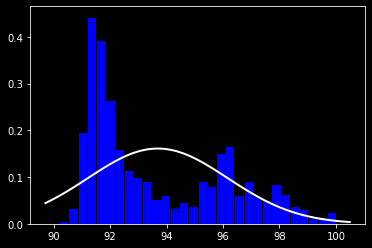

In [84]:
plt.hist(rdrp_identitydf['pident'], bins=30, density=True, alpha=1, color='b', edgecolor='black')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(rdrp_identitydf['pident']), np.std(rdrp_identitydf['pident']))
plt.plot(x, p, 'k', linewidth=2, color='white')

/var/folders/pv/bx8g6vks3015p3svg5x_1h540000gn/T/ipykernel_9851/2682225059.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(x, p, 'k', linewidth=2, color='white')


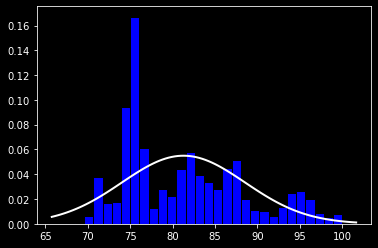

In [88]:
plt.hist(spike_identitydf['pident'], bins=30, density=True, alpha=1, color='b', edgecolor='black')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, np.mean(spike_identitydf['pident']), np.std(spike_identitydf['pident']))
plt.plot(x, p, 'k', linewidth=2, color='white')

In [104]:
msa_metadata = pd.read_csv('/Users/zirui/BGI_Projects/GIZ_SouthernChinaBats/BatSarbecovirus_20231123/msa_metadata.csv').drop('seqheader', axis=1)
msa_metadata['bat_species'] = msa_metadata['bat_species'].apply(lambda x: x.replace('_', ' ').replace('Ferrumequinum','ferrumequinum'))
msa_metadata['seqid'] = msa_metadata['seqid'].astype(str)
msa_metadata

,seqid,province,bat_species
0,HD13589,Guangdong,Rhinolophus sinicus
1,B68,Guangdong,Rhinolophus sinicus
2,201924,Guangdong,Rhinolophus sinicus
3,B50,Guangdong,Rhinolophus sinicus
4,CH231,Guangdong,Rhinolophus sinicus
...,...,...,...
163,OQ503502.1,Yunnan,Rhinolophus sinicus
164,OQ503503.1,Yunnan,Rhinolophus sinicus
165,OQ503504.1,Yunnan,Rhinolophus sinicus
166,OQ503505.1,Yunnan,Rhinolophus sinicus


In [105]:
merge_identity = pd.merge(rdrp_identitydf, spike_identitydf, on=['Accession_1', 'Accession_2'], suffixes=['_nsp', '_spike'])
merge_identity

,Accession_1,Accession_2,match_nsp,mismatch_nsp,gap_nsp,alnlen_nsp,msalen_nsp,pident_nsp,pident_standardized_nsp,match_spike,mismatch_spike,gap_spike,alnlen_spike,msalen_spike,pident_spike,pident_standardized_spike
0,OK017834.1,KF367457.1,6901,608,0,7509,7512,91.903050,0.980934,2905,894,104,3799,4081,76.467491,0.940834
1,OK017834.1,201924,6922,587,0,7509,7512,92.182714,0.983919,3076,656,12,3732,4081,82.422294,1.014100
2,OK017834.1,OK017832.1,7050,459,0,7509,7512,93.887335,1.002114,2920,835,79,3755,4081,77.762983,0.956773
3,OK017834.1,KY770858.1,6918,591,0,7509,7512,92.129445,0.983351,3042,690,39,3732,4081,81.511254,1.002891
4,OK017834.1,KY770860.1,6938,571,0,7509,7512,92.395792,0.986194,2978,752,11,3730,4081,79.839142,0.982317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7498,DQ648856.1,OK017825.1,6891,618,0,7509,7512,91.769876,0.979513,3062,668,5,3730,4081,82.091153,1.010026
7499,DQ648856.1,OK017842.1,6866,643,0,7509,7512,91.436942,0.975959,2973,757,8,3730,4081,79.705094,0.980668
7500,OQ503495.1,OK017825.1,6981,528,0,7509,7512,92.968438,0.992306,3567,162,3,3729,4081,95.655672,1.176919
7501,OQ503495.1,OK017842.1,6932,577,0,7509,7512,92.315888,0.985341,3108,621,6,3729,4081,83.346742,1.025474


In [106]:
merge_info = merge_identity.merge(msa_metadata, left_on='Accession_1', right_on='seqid', how='left').merge(msa_metadata, left_on='Accession_2', right_on='seqid', suffixes=['_1', '_2'], how='left')
merge_info

,Accession_1,Accession_2,match_nsp,mismatch_nsp,gap_nsp,alnlen_nsp,msalen_nsp,pident_nsp,pident_standardized_nsp,match_spike,...,alnlen_spike,msalen_spike,pident_spike,pident_standardized_spike,seqid_1,province_1,bat_species_1,seqid_2,province_2,bat_species_2
0,OK017834.1,KF367457.1,6901,608,0,7509,7512,91.903050,0.980934,2905,...,3799,4081,76.467491,0.940834,OK017834.1,Hunan,Rhinolophus sinicus,KF367457.1,Yunnan,Rhinolophus sinicus
1,OK017834.1,201924,6922,587,0,7509,7512,92.182714,0.983919,3076,...,3732,4081,82.422294,1.014100,OK017834.1,Hunan,Rhinolophus sinicus,201924,Guangdong,Rhinolophus sinicus
2,OK017834.1,OK017832.1,7050,459,0,7509,7512,93.887335,1.002114,2920,...,3755,4081,77.762983,0.956773,OK017834.1,Hunan,Rhinolophus sinicus,OK017832.1,Hunan,Rhinolophus sinicus
3,OK017834.1,KY770858.1,6918,591,0,7509,7512,92.129445,0.983351,3042,...,3732,4081,81.511254,1.002891,OK017834.1,Hunan,Rhinolophus sinicus,KY770858.1,Guangxi,Rhinolophus sinicus
4,OK017834.1,KY770860.1,6938,571,0,7509,7512,92.395792,0.986194,2978,...,3730,4081,79.839142,0.982317,OK017834.1,Hunan,Rhinolophus sinicus,KY770860.1,Henan,Rhinolophus ferrumequinum
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7498,DQ648856.1,OK017825.1,6891,618,0,7509,7512,91.769876,0.979513,3062,...,3730,4081,82.091153,1.010026,DQ648856.1,Hubei,Rhinolophus ferrumequinum,OK017825.1,Guangdong,Rhinolophus sinicus
7499,DQ648856.1,OK017842.1,6866,643,0,7509,7512,91.436942,0.975959,2973,...,3730,4081,79.705094,0.980668,DQ648856.1,Hubei,Rhinolophus ferrumequinum,OK017842.1,Jiangxi,Rhinolophus sinicus
7500,OQ503495.1,OK017825.1,6981,528,0,7509,7512,92.968438,0.992306,3567,...,3729,4081,95.655672,1.176919,OQ503495.1,Guangdong,Rhinolophus sinicus,OK017825.1,Guangdong,Rhinolophus sinicus
7501,OQ503495.1,OK017842.1,6932,577,0,7509,7512,92.315888,0.985341,3108,...,3729,4081,83.346742,1.025474,OQ503495.1,Guangdong,Rhinolophus sinicus,OK017842.1,Jiangxi,Rhinolophus sinicus


In [102]:
merge_info['Same_Host'] = merge_info['bat_species_1'] == merge_info['bat_species_2']
merge_info['Same_Province'] = merge_info['province_1'] == merge_info['province_2']

In [103]:
merge_info.to_excel('ANI_nsp_spike_v5.xlsx', index=False)